In [3]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

def Euclidean(x,y):
    return np.sqrt((y[0]-x[0])**2 + (y[1] - x[1])**2)

In [4]:
# For webcam input:
from ast import ListComp

calcThis = False
if calcThis:
  datadirectory = 'data'
  PoseData = list()
  # cap = cv2.VideoCapture(0)
  cap = cv2.VideoCapture(os.path.join('..', datadirectory, 'MariaDancingSequence.webm'))
  i = 0
  imageName = "MariaMovementSequence_xyz_28Sept"
  # MaxRecordings = 10
  pose = mp_pose.Pose(
      min_detection_confidence=0.5,
      min_tracking_confidence=0.5)  # as pose:

  while cap.isOpened():
    
    i += 1
    
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      break

    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    results = pose.process(image)
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    
    newData = {coord + str(j):lm.__getattribute__(coord)  for j, lm in enumerate(results.pose_landmarks.landmark) for coord in ["x", "y", "z"]}
    PoseData.append(newData)

    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
    if (cv2.waitKey(5) & 0xFF == 27): ## or i>MaxRecording s :
      break
  cap.release()
  df = pd.DataFrame(PoseData)
  df.to_csv(os.path.join("..","data", "csv", imageName + ".csv"))
  cv2.destroyAllWindows()

In [ ]:
if calcThis:
    cap.release()
    cv2.destroyAllWindows()

In [5]:
import cv2
images = []
cap = cv2.VideoCapture(os.path.join('..', 'data', 'MariaDancingSequence.webm'))
# for i in range(315):
fromFrame = 0
tillFrame = 815
lastSuccessfulFrame = 0
numberOfsuccessivUnsuccessesToBreak = 20
unsuccesses = 0
frame = 0
while unsuccesses < numberOfsuccessivUnsuccessesToBreak:
  success, image = cap.read()
  if success and (frame>=fromFrame and frame<=tillFrame):
    images.append(image)
  else:
    images.append('empty')

  if not success:
    unsuccesses += 1
  else:
    unsuccesses = 0
    lastSuccessfulFrame = frame

  frame += 1

cap.release()

durationOfClip = (2 * 60 + 42)
fps = int((lastSuccessfulFrame) / durationOfClip)

Load the data from the cvs storage

In [6]:
fileName = "MariaMovementSequence_xyz_27Sept"
df = pd.read_csv(
    os.path.join("..","data", "csv", fileName + ".csv"), 
    header=0,
    index_col=0)
df["time"] = 1000 * df.index / fps

In [7]:
landmarks = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]
index_from_landmark = {name: i for i,name in enumerate(landmarks)}

In [ ]:
import matplotlib.pyplot as plt
startAt = 276
steps = 7
ncols = 3
fig, axes = plt.subplots(nrows=3, ncols=ncols)
# frame = startAt
for i in range(6):
    row = round(np.floor(i/ncols))
    col = i % ncols
    timeframe = (startAt + (i * steps))
    time = round(timeframe / fps, 1)
    axes[row,col].imshow(images[timeframe])
    axes[row,col].set_title('time in seconds {}'.format(time))
these = [index_from_landmark[i] for i in ['left_hip', 'right_hip', 'left_knee', 'right_knee']]
# print( [landmarks[i] for i in these])
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['x' + str(i) for i in these], ax=axes[2,0])
axes[2,0].set_title('x-coords')
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['y' + str(i) for i in these], ax=axes[2,1])
axes[2,1].set_title('y-coords')
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['z' + str(i) for i in these], ax=axes[2,2])
axes[2,2].set_title('z-coords')
fig.set_size_inches(28.5, 15.0)
# fig.set_size_inches(18.5, 8.0)
plt.show()

## Analysis

In [8]:
Annotations = {
    "hip_joint_right": [
        {"from": "00:05:12", "till": "00:07:11"},
        {"from": "00:44:03", "till": "00:46:03"}],
    "elbow_hinge_left": [
        {"from": "00:07:14", "till":"00:11:07"},
        {"from": "00:46:03", "till":"00:48:06"}],
    "pivot_right":[{"from": "00:48:07", "till": "00:49:13"}],
    "pivot_left":[{"from": "00:50:04", "till": "00:52:03"}],
    "rotation_shoulder_left": [{"from": "00:11:08" , "till":"00:14:02"}],
    "thumb_movement_left": [{"from": "00:14:03", "till": "00:18:10"}],
    "knee_hinge_right":[{"from":"00:18:11", "till": "00:21:01"}]
}

In [9]:
def lightenUp(x, byFactor=2):
    return np.add(x, np.divide((255 - x), byFactor)).astype(int)

def kdenLiveTimeToFrame(time, fps=15):
    secs = time.split(":")
    return int(secs[0]) * 60 + int(secs[1]) * fps + int(secs[2])
    

In [ ]:
startAt = int(Annotations["leg_turn"]["from"] * fps / 1000)
steps = 3
ncols = 3
fig, axes = plt.subplots(nrows=3, ncols=ncols)
# frame = startAt
for i in range(6):
    row = round(np.floor(i/ncols))
    col = i % ncols
    timeframe = (startAt + (i * steps))
    time = round(timeframe / fps, 1)
    # print(timeframe)
    axes[row,col].imshow(lightenUp(images[timeframe], 5))
    axes[row,col].set_title('time in seconds {}'.format(time))
these = [index_from_landmark[i] for i in ['left_hip', 'right_hip', 'left_knee', 'right_knee',
'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index']]
# print( [landmarks[i] for i in these])
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['x' + str(i) for i in these], ax=axes[2,0])
axes[2,0].set_title('x-coords')
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['y' + str(i) for i in these], ax=axes[2,1])
axes[2,1].set_title('y-coords')
df[(df.index>=startAt) & (df.index <= timeframe)].plot(x="time", y=['z' + str(i) for i in these], ax=axes[2,2])
axes[2,2].set_title('z-coords')
fig.set_size_inches(28.5, 15.0)
# fig.set_size_inches(18.5, 8.0)
plt.show()

## Gaussian Mixture Models

In [10]:
import numpy as np
from sklearn.mixture import GaussianMixture
import time

### Generate training data

In [46]:
def rescaleEntry(name, x, zero, scale):
    if name.startswith('x'):
        return (x - zero[0]) / scale
    elif name.startswith('y'):
        return (x - zero[1]) / scale
    elif name.startswith('z'):
        return (x - zero[2]) / scale
    else:
        return x

In [51]:
def rescale(x):
    ## nose is 0
    nose = np.array([coord for name, coord in x.items() if name[1:] == str(index_from_landmark['nose'])])
    leftEye = np.array([coord for name, coord in x.items() if name[1:] == str(index_from_landmark['left_eye_outer'])])
    rightEye = np.array([coord for name, coord in x.items() if name[1:] == str(index_from_landmark['right_eye_outer'])])
    scale = np.linalg.norm(leftEye - rightEye)
    return {(name + "_rescaled" if name[0] in ['x', 'y', 'z'] else name) : rescaleEntry(name, coord, nose, scale) for name, coord in x.items()}


In [52]:
df_rescaled_list = list()
for i, row in df.iterrows():
    df_rescaled_list.append(rescale(row))
df_rescaled = pd.DataFrame(df_rescaled_list).drop(["x0_rescaled", "y0_rescaled", "z0_rescaled"], axis=1)

In [ ]:
X = GMM = GaussianMixture(n_components=3, random_state=0).fit(X)

In [75]:
def generateDataFromAnnotation(df, anno, batch_size=4):
    result = dict()
    onlyCoordinateColumns = [c for c in df.columns if c[0] in ['x', 'y', 'z']]
    for name, speclist in anno.items():
        # print(name)
        result_list = list()
        for specs in speclist:
            fr = kdenLiveTimeToFrame(specs["from"])
            to = kdenLiveTimeToFrame(specs["till"])
            till = to - batch_size + 1
            if till < fr:
                continue
            for i in range(fr, till + 1):
                dat = df.loc[(fr + i):(fr + i + batch_size), onlyCoordinateColumns]
                result_list.append(dat.to_numpy().flatten())
        result[name] = np.array(result_list)

    return result


In [76]:
result = generateDataFromAnnotation(df=df_rescaled, anno=Annotations, batch_size=3)

In [80]:
allResults = np.vstack(tuple(result.values()))


In [82]:
GMM = GaussianMixture(n_components=len(Annotations.keys()), random_state=0).fit(allResults)

In [83]:
labels = GMM.predict(allResults)

In [85]:
from matplotlib import pyplot as plt

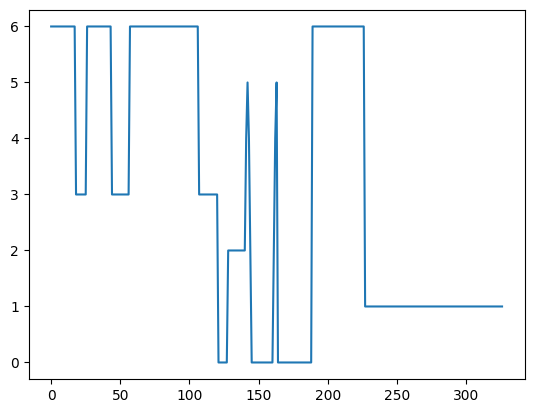

In [87]:
plt.plot(labels)
plt.show()

In [88]:
GMM.score(allResults[])

array([0.14678899, 0.3058104 , 0.04587156, 0.10703364, 0.00917431,
       0.00611621, 0.37920489])